# gensim doc2vec & IMDB sentiment dataset

TODO: section on introduction & motivation

TODO: prerequisites + dependencies (statsmodels, patsy, ?)

## Load corpus

Fetch and prep exactly as in Mikolov's go.sh shell script. (Note this cell tests for existence of required files, so steps won't repeat once the final summary file (`aclImdb/alldata-id.txt`) is available alongside this notebook.)

In [1]:
import pandas as pd
import cloudpickle
import numpy as np

In [18]:
df = cloudpickle.load(open("pickles/cleaned_forum_data.pkl", "rb" ) )

totest=20000

asktxt = df['askertxt'].as_matrix()[:totest]
doctxt = df['doctortxt'].as_matrix()[:totest]

diag = cloudpickle.load(open("pickles/doctortext_labels.pkl", "rb" ) )[:totest,:]
y=np.asarray(diag.todense()).squeeze()
y=y[:,y.sum(axis=0)>200]

In [19]:
y.shape

(20000, 15)

In [20]:
## import gensim, string
from gensim.models.doc2vec import LabeledSentence
from collections import namedtuple
import string

alldocs = []  # will hold all docs in original order
alltxts = []
for line_no, line in enumerate(asktxt):
#     words = my_normalize_nostem(line)
    words = line.lower().translate(string.maketrans(string.punctuation, ' '*len(string.punctuation))).split()
    tags = [line_no] # `tags = [tokens[0]]` would also work at extra memory cost
    alldocs.append(LabeledSentence(words, tags))
    alltxts.append(words)
    
# for line_no, line in enumerate(doctxt):
# #     words = my_normalize_nostem(line)
#     words = line.lower().translate(string.maketrans(string.punctuation, ' '*len(string.punctuation))).split()
#     tags = [len(asktxt)+line_no] # `tags = [tokens[0]]` would also work at extra memory cost
#     alldocs.append(LabeledSentence(words, tags))

txt_list = np.array(alltxts)
doc_list = alldocs[:]  # for reshuffling per pass

## Set-up Doc2Vec Training & Evaluation Models

Approximating experiment of Le & Mikolov ["Distributed Representations of Sentences and Documents"](http://cs.stanford.edu/~quocle/paragraph_vector.pdf), also with guidance from Mikolov's [example go.sh](https://groups.google.com/d/msg/word2vec-toolkit/Q49FIrNOQRo/J6KG8mUj45sJ):

`./word2vec -train ../alldata-id.txt -output vectors.txt -cbow 0 -size 100 -window 10 -negative 5 -hs 0 -sample 1e-4 -threads 40 -binary 0 -iter 20 -min-count 1 -sentence-vectors 1`

Parameter choices below vary:

* 100-dimensional vectors, as the 400d vectors of the paper don't seem to offer much benefit on this task
* similarly, frequent word subsampling seems to decrease sentiment-prediction accuracy, so it's left out
* `cbow=0` means skip-gram which is equivalent to the paper's 'PV-DBOW' mode, matched in gensim with `dm=0`
* added to that DBOW model are two DM models, one which averages context vectors (`dm_mean`) and one which concatenates them (`dm_concat`, resulting in a much larger, slower, more data-hungry model)
* a `min_count=2` saves quite a bit of model memory, discarding only words that appear in a single doc (and are thus no more expressive than the unique-to-each doc vectors themselves)

In [21]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


d2v_vectorizers = [
    # PV-DM w/concatenation - window=5 (both sides) approximates paper's 10-word total window size
#     ('d2v-sg-concat-100', Doc2Vec(dm=1, dm_concat=1, size=100, window=5, negative=5, hs=0, min_count=2, workers=cores)),
    # PV-DM w/concatenation - window=5 (both sides) approximates paper's 10-word total window size
#     ('d2v-sg-concat-200', Doc2Vec(dm=1, dm_concat=1, size=200, window=5, negative=5, hs=0, min_count=2, workers=cores)),
    # PV-DBOW 
    ('d2v-cbow', Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)),
    # PV-DM w/average
    ('d2v-sg-mean-100', Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)),
    # PV-DM w/average
#     ('d2v-sg-mean-200', Doc2Vec(dm=1, dm_mean=1, size=200, window=10, negative=5, hs=0, min_count=2, workers=cores)),
]

# speed setup by sharing results of 1st model's vocabulary scan
d2v_vectorizers[0][1].build_vocab(alldocs)  # PV-DM/concat requires one special NULL word so it serves as template
print(d2v_vectorizers[0][0])
for name,vec in d2v_vectorizers[1:]:
    vec.reset_from(d2v_vectorizers[0][1])
    print(name)

vec_represent = {}
    
for name,vec in d2v_vectorizers:
    print('Training vectorizer %s' % name)

    # train
    vec.min_alpha=vec.alpha
    %time vec.train(doc_list)
    vec_represent[name]=[vec.infer_vector(doc.words) for doc in doc_list]


plain_vectorizers = [
    ('tfidf',TfidfVectorizer(analyzer=lambda x: x, stop_words='english', ngram_range=(1,3), max_df=0.4, max_features=8000, min_df=0.01),),
#     ('bagofwords',CountVectorizer(analyzer=lambda x: x, stop_words='english', max_df=0.4, max_features=8000, min_df=0.01))
]

for name_vec,vec in plain_vectorizers:
    print('Training vectorizer %s' % name_vec)
    %time vec.fit(txt_list)
    vec_represent[name_vec]=vec.transform(txt_list)

d2v-cbow
d2v-sg-mean-100
Training vectorizer d2v-cbow
CPU times: user 55.5 s, sys: 2.16 s, total: 57.7 s
Wall time: 26.3 s
Training vectorizer d2v-sg-mean-100
CPU times: user 1min 40s, sys: 3.49 s, total: 1min 44s
Wall time: 46.9 s
Training vectorizer tfidf
CPU times: user 3.67 s, sys: 92 ms, total: 3.76 s
Wall time: 6.07 s


# save/load checkpoint

In [21]:
# with open("d2v_vectorizers.pkl", 'wb') as handle:
#     cloudpickle.dump(d2v_vectorizers, handle)
# with open("plain_vectorizers.pkl", 'wb') as handle:
#     cloudpickle.dump(plain_vectorizers, handle)
# with open("vector_representations.pkl", 'wb') as handle:
#     cloudpickle.dump(vec_represent, handle)

In [6]:
# d2v_vectorizers=cloudpickle.load(open("d2v_vectorizers.pkl", "rb" ) )
# plain_vectorizers=cloudpickle.load(open("plain_vectorizers.pkl", "rb" ) )
# vec_represent=cloudpickle.load(open("vector_representations.pkl", "rb" ) )

## Bulk Training

Using explicit multiple-pass, alpha-reduction approach as sketched in [gensim doc2vec blog post](http://radimrehurek.com/2014/12/doc2vec-tutorial/) – with added shuffling of corpus on each pass.

Note that vector training is occurring on *all* documents of the dataset, which includes all TRAIN/TEST/DEV docs.

Evaluation of each model's sentiment-predictive power is repeated after each pass, as an error rate (lower is better), to see the rates-of-relative-improvement. The base numbers reuse the TRAIN and TEST vectors stored in the models for the logistic regression, while the _inferred_ results use newly-inferred TEST vectors. 

(On a 4-core 2.6Ghz Intel Core i7, these 20 passes training and evaluating 3 main models takes about an hour.)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

# start with the classics - naive bayes of the multinomial and bernoulli varieties
# with either pure counts or tfidf features
# SVM - which is supposed to be more or less state of the art 
# http://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf

# use this when you have multi-labels
# svc = OneVsRestClassifier(SVC(kernel="linear"))

n_estimators = 10
svc = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear'), max_samples=1.0 / n_estimators, n_estimators=n_estimators))
logreg = OneVsRestClassifier(LogisticRegression())
etree = ExtraTreesClassifier(n_estimators=10)

#need to add k nearest neighbors
all_models = [
    ("logistic", logreg),
#     ("svc", svc),
    ("etree", etree)
]

In [ ]:
import datetime
from sklearn.base import clone


print("START %s" % datetime.datetime.now())

scores=[]
for name_vec, rep in vec_represent.items():    
    print('Using vectorizer %s' % name_vec)
    X = np.array(rep) if isinstance(rep,list) else np.array(rep.todense())
    for name_mod, model0 in all_models:
        model = clone(model0)
        print('Training model %s' % name_mod)
        build_score=[]#cross_val_score(model,X,y)
        for train,test in StratifiedShuffleSplit(y, n_iter=5, test_size=0.25):
            X_train, X_test = X[train], X[test]
            y_train, y_test = y[train], y[test]
            %time model.fit(X_train, y_train)
            score = %time accuracy_score(model.predict(X_test), y_test)
            build_score.append(score)
        build_score=np.array(build_score)
        del model
        scores.append(("vec="+name_vec+", model="+name_mod, build_score.mean(),build_score.std()))
        
        
        
print("END %s" % str(datetime.datetime.now()))

START 2016-10-04 11:23:17.002729
Using vectorizer tfidf
Training model logistic
CPU times: user 1min 59s, sys: 640 ms, total: 2min
Wall time: 2min 27s
CPU times: user 3.48 s, sys: 16 ms, total: 3.5 s

## Achieved Sentiment-Prediction Accuracy

model                                    score     std
-------------------------------------  -------  ------
vec=d2v-sg-mean-100, model=etree        1.0000  0.0000
vec=d2v-cbow, model=etree               1.0000  0.0000
vec=d2v-sg-concat-100, model=etree      1.0000  0.0000
vec=tfidf, model=etree                  0.9991  0.0001
vec=tfidf, model=logistic               0.7950  0.0019
vec=d2v-cbow, model=logistic            0.7508  0.0019
vec=d2v-sg-mean-100, model=logistic     0.7278  0.0015
vec=d2v-sg-concat-100, model=logistic   0.7211  0.0019


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

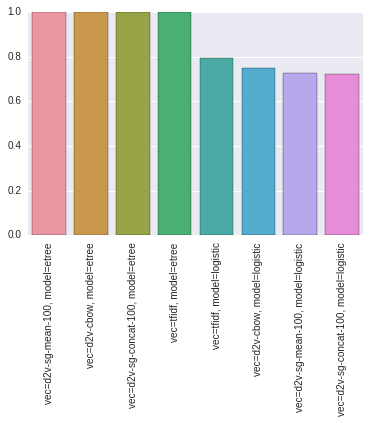

In [13]:
# print best error rates achieved
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

scores = sorted(scores, key=lambda (a,x,b): -x)

print tabulate(scores, floatfmt=".4f", headers=("model", 'score','std'))

# plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name,a,b in scores], y=[score for a, score,b in scores])
plt.xticks(rotation=90)

### Finding the important features for each disease_label

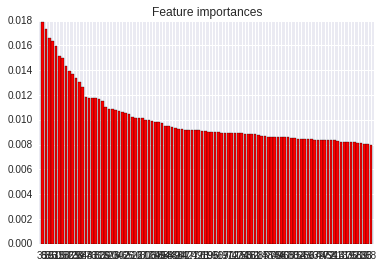

In [14]:
X = np.array(vec_represent['d2v-cbow'])
forest = clone(etree)

forest.fit(X, y)
importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

(Somewhat, in terms of reviewer tone, movie genre, etc... the MOST cosine-similar docs usually seem more like the TARGET than the MEDIAN or LEAST.)

### TODO: vary the dataset size and see how the accuracy improves?

In [120]:
def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

train_sizes = [10, 40, 160, 640, 3200, 6400]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")

most similar words for 'ovulations' (59 occurences)


"Doc2Vec(dm/c,d100,n5,w5,mc2,t4)","Doc2Vec(dbow,d100,n5,mc2,t4)","Doc2Vec(dm/m,d100,n5,w10,mc2,t4)"
"[('menstruations', 0.5418837070465088), ('partners', 0.5205096006393433), ('ovulation', 0.514448881149292), ('failures', 0.4933128356933594), ('cycles', 0.4877683222293854), ('headacks', 0.4839607775211334), ('miscarriages', 0.4822285771369934), ('ejaculation', 0.47940289974212646), ('hypodensities', 0.4678962826728821), ('utis', 0.4677923321723938), ('gestations', 0.4645574688911438), ('hospitalizations', 0.4627258777618408), ('ageing', 0.4553208649158478), ('epts', 0.4543471336364746), ('pregnacies', 0.45407208800315857), ('deliveries', 0.44855940341949463), ('orgasims', 0.44456303119659424), ('fertilization', 0.4433467984199524), ('hyperandrogenism', 0.4425516426563263), ('mris', 0.44202157855033875)]","[('h', 0.42999568581581116), ('img288', 0.3869835138320923), ('schistosoma', 0.3724989891052246), ('aniti', 0.3607182502746582), ('bfor', 0.35129716992378235), ('scope', 0.3445971608161926), ('membranous', 0.3445863425731659), ('swole', 0.3431397080421448), ('rail', 0.3425341844558716), ('plump', 0.3358010947704315), ('pilss', 0.3317587375640869), ('represent', 0.3310645818710327), ('reccommended', 0.32871949672698975), ('pal', 0.3271971344947815), ('dyndns', 0.326257586479187), ('seizures', 0.32475045323371887), ('wheat', 0.3244967460632324), ('messege', 0.320811927318573), ('uncertainty', 0.3203224837779999), ('emotions', 0.3202061951160431)]","[('numbered', 0.447348952293396), ('dysmenorrhea', 0.4230629503726959), ('intervention', 0.4111103415489197), ('menstruations', 0.3920370936393738), ('specifying', 0.3900192677974701), ('benzydamine', 0.3861333131790161), ('hypodensities', 0.3749895691871643), ('dimensions', 0.36975038051605225), ('hookups', 0.3591601848602295), ('diplopia', 0.3562808632850647), ('periodic', 0.352350115776062), ('laryngopharyngeal', 0.3507871925830841), ('consent', 0.3494877219200134), ('simptoms', 0.3455832004547119), ('observation', 0.34256434440612793), ('rifampicin', 0.3422098755836487), ('uncooked', 0.34216052293777466), ('examining', 0.3410031199455261), ('generations', 0.3403622508049011), ('egges', 0.339042603969574)]"
